# Download

In [1]:
WORKING_ENV = 'LOCAL' # Can be LABS, COLAB or PAPERSPACE
assert WORKING_ENV in ['LABS', 'COLAB', 'LOCAL']

import sys
import os
if WORKING_ENV == 'COLAB':
  from google.colab import drive
  drive.mount('/content/drive/')
  !pip install medmnist
  !pip install torch
  !pip install gputil
  !pip install psutil
  !pip install humanize
  ROOT = "/content/drive/MyDrive/ColabNotebooks/med-contrastive-project/"
  sys.path.append(ROOT + "./supervised/")
  !nvidia-smi
  slurm_id = 0
elif WORKING_ENV == 'LABS':
  ROOT = "/vol/bitbucket/sx119/Contrastive-Medical-Image-Classification/"
  slurm_id = os.environ["SLURM_JOB_ID"]
else:
  ROOT = "/Users/xushitong/Contrastive-Medical-Image-Classification/"
  slurm_id = 0

# Import

In [2]:
import medmnist

import argparse
import builtins
import math
import os
import random
import shutil
import time
import tqdm
import warnings

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
# import torch.distributed as dist
import torch.optim
import torch.multiprocessing as mp
import torch.utils.data
# import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from PIL import ImageFilter


/Users/xushitong/miniconda3/envs/med-contrast-env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)
print("using device: ", dev)


using device:  cpu


In [4]:
# Import packages
import os,sys,humanize,psutil,GPUtil

# Define function
def mem_report():
  print("CPU RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ))
  
  GPUs = GPUtil.getGPUs()
  for i, gpu in enumerate(GPUs):
    print('GPU {:d} ... Mem Free: {:.0f}MB / {:.0f}MB | Utilization {:3.0f}%'.format(i, gpu.memoryFree, gpu.memoryTotal, gpu.memoryUtil*100))

mem_report()

CPU RAM Free: 12.4 GB
GPU 0 ... Mem Free: 15098MB / 15360MB | Utilization   0%


# Hyperparameters

In [3]:
EPOCH_NUM = 15
BATCH_SIZE = 128
LEARNING_RATE = 0.03
MOMENTUM = 0.9 # momentum of SGD
WEIGHT_DECAY = 1e-4 # weight decay for SGD
ON_PRETRAINED = False # if trained on pre-training set or on validation set
if ON_PRETRAINED:
  PRINT_FREQ = 200
else:
  PRINT_FREQ = 20
COLOUR_AUG = True

trial_name = f"epoch{EPOCH_NUM}_batch{BATCH_SIZE}_lr{LEARNING_RATE}_momentum{MOMENTUM}_wd{WEIGHT_DECAY}_on-pretrain{ON_PRETRAINED}_aug-colour{COLOUR_AUG}"

print("trial name: " + trial_name)

trial name: epoch15_batch128_lr0.03_momentum0.9_wd0.0001_on-pretrainFalse_aug-colourTrue


# Dataset

In [4]:
class SupervisedDataset():
    """Dataset that applies given data augmentation to each image"""

    def __init__(self, path, augmentation):
        self.samples = torch.load(path)
        self.augmentation = transforms.Compose(augmentation)

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        image, label = self.samples[index]
        return self.augmentation(image), label
    
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


In [6]:
# Data loading code
# traindir = os.path.join(args.data, 'train')
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
if COLOUR_AUG:
    augmentation = [
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]
else:
    augmentation = [
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]

# # proper dataset loading, by loading pre-splitted data
pretrain_set = SupervisedDataset(ROOT + "/datasets/pretrain_set.data", augmentation=augmentation)
pretrain_val_set = SupervisedDataset(ROOT + "/datasets/pretrain_val_set.data", augmentation=augmentation)

dev_train_set = SupervisedDataset(ROOT + "/datasets/dev_train_set.data", augmentation=augmentation)
dev_val_set = SupervisedDataset(ROOT + "/datasets/dev_val_set.data", augmentation=augmentation)

test_dataset = medmnist.PathMNIST("test", download=False, root=ROOT + "/datasets/", 
                                  transform=transforms.Compose([
                                    transforms.Resize(224),
                                    transforms.ToTensor(),
                                    normalize
                                  ]))

pretrain_loader = torch.utils.data.DataLoader(
    pretrain_set, batch_size=BATCH_SIZE, shuffle=True, 
    pin_memory=True, drop_last=True)
pretrain_val_loader = torch.utils.data.DataLoader(
    pretrain_val_set, batch_size=2 * BATCH_SIZE, shuffle=False, 
    pin_memory=True, drop_last=True)

dev_train_loader = torch.utils.data.DataLoader(
    dev_train_set, batch_size=BATCH_SIZE, shuffle=True, 
    pin_memory=True, drop_last=True)
dev_val_loader = torch.utils.data.DataLoader(
    dev_val_set, batch_size=2 * BATCH_SIZE, shuffle=False, 
    pin_memory=True, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=2 * BATCH_SIZE, shuffle=False, 
    pin_memory=True, drop_last=True)

print(f"pretrain size: {len(pretrain_set)}\npretrain validation size: {len(pretrain_val_set)}\ndev train size: {len(dev_train_set)}\ndev val size: {len(dev_val_set)}\ntest size: {len(test_dataset)}")


pretrain size: 80996
pretrain validation size: 9000
dev train size: 9003
dev val size: 1001
test size: 7180


# Train

In [10]:
if WORKING_ENV == 'LABS':
  summary = open(f"{slurm_id}_{trial_name}.txt", "a")
else:
  summary = sys.stdout


# create model
model = models.resnet50()
model.add_module("projection_head", nn.Linear(1000, 9))
model = model.to(device)

criterion = nn.CrossEntropyLoss(reduction="mean")

optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE, momentum=0.9, weight_decay=1e-4)

def train_func(img, label, train=True, return_y=False):
  # train/evaluate on given data for one mini batch 
  img = img.to(device)
  label = label.to(device)

  if train:
    model.train()
  else:
    model.eval()

  label_hat = model(img)
  l = criterion(label_hat, label.squeeze())

  if train:
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

  if return_y:
    return l, label_hat
  return l


In [ ]:
for epoch in range(EPOCH_NUM):
  acc_l = 0
  if ON_PRETRAINED:
    loader = pretrain_loader
    val_loader = pretrain_val_loader
  else:
    loader = dev_train_loader
    val_loader = dev_val_loader
  with tqdm.tqdm(loader, unit="batch") as tepoch: 
    if WORKING_ENV == "LABS":
      tepoch = loader
    for i, (img, label) in enumerate(tepoch):
      l = train_func(img, label)
      acc_l += l.item()

      if i % PRINT_FREQ == 0 and i != 0:
        if WORKING_ENV == 'LABS':
          print(f"batch {i} loss: {l.item()}")
        else:
          tepoch.set_description(f"batch {i}")
          tepoch.set_postfix(loss=l.item())

        acc_val_l = 0
        with torch.no_grad():
          for img, label in val_loader:
            l = train_func(img, label, False)
            acc_val_l += l.item()

        summary.write(f"Epoch {epoch}[{i}]: loss: {l.item()}({acc_l / (i + 1)}), val loss: {acc_val_l / len(val_loader)}\n")

In [ ]:
torch.save(model, f"{slurm_id}_{trial_name}.pickle")
mem_report()

# Quantitative Evaluation

In [ ]:
acc_l = 0
confusion_matrix = torch.zeros((9, 9))
with torch.no_grad():
  for (img, label) in test_loader:
    l, label_hat = train_func(img, label, train=False, return_y=True)
    acc_l += l

    for i in range(label.shape[0]):
      confusion_matrix[label[i].item(), label_hat[i].argmax().item()] += 1

acc_f1 = 0
for i in range(confusion_matrix.shape[0]):
  recall = confusion_matrix[i, i] / confusion_matrix[i].sum()
  precision = confusion_matrix[i, i] / confusion_matrix[:, i].sum()
  acc_f1 += 2 / (1 / precision + 1 / recall)

torch.save(confusion_matrix, f"{slurm_id}_{trial_name}_confusion_matrix.pickle")
summary.write(f"test set loss: {acc_l / len(test_loader)}, macro F1: {acc_f1 / confusion_matrix.shape[0]}\n")


# Metric evaluation

In [8]:
import re
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE


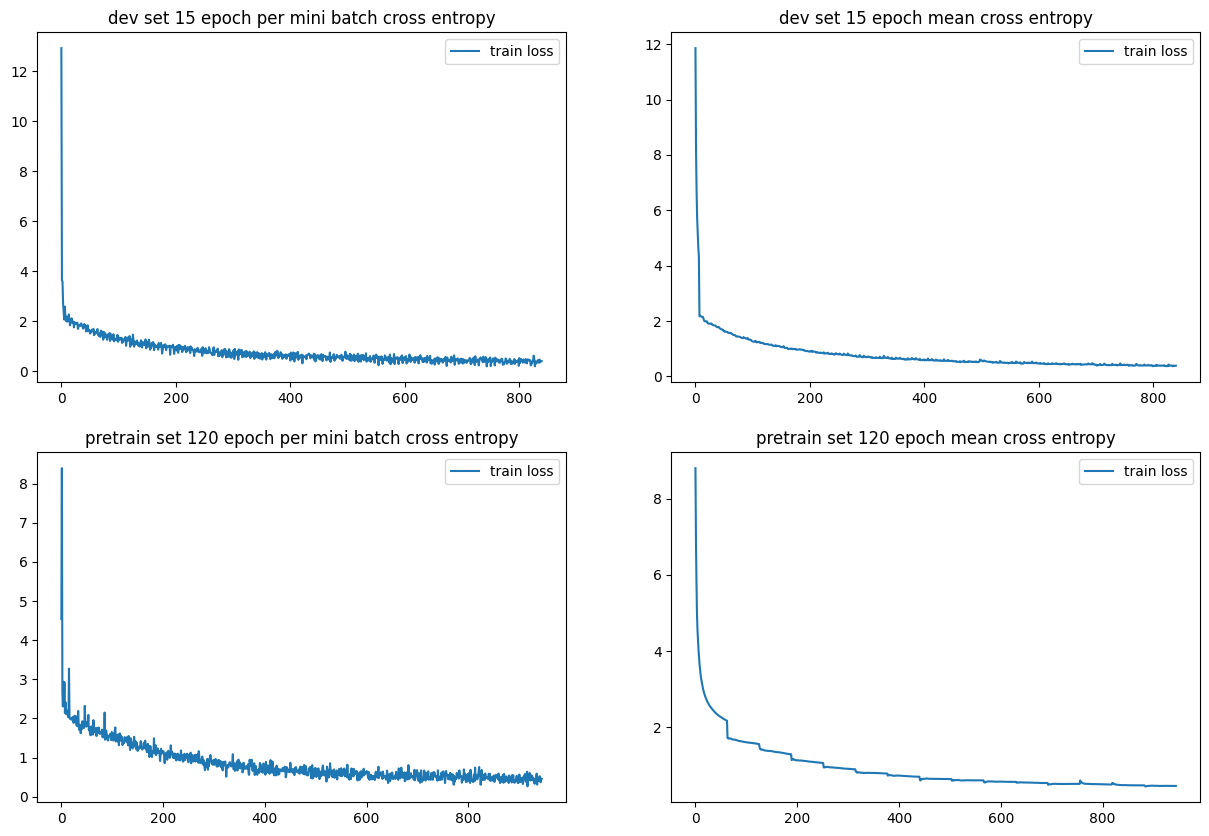

In [9]:
def extract_float(file_name, start="Epoch"):
  def isfloat(word):
    try:
      float(word)
      return True
    except ValueError:
      return False
  file = open(file_name)
  l = [[float(word) for word in re.split("\n|,| |\t|\(|\)|\[|\]", line) if isfloat(word)] for line in file if line.startswith(start)]
  return torch.tensor(l)

# general propose plot
file_names = [
  "./71067_epoch120_batch128_lr0.03_momentum0.9_wd0.0001_on-pretrainFalse.txt",
  "./71019_epoch15_batch128_lr0.03_momentum0.9_wd0.0001_on-pretrainTrue.txt",
]
fig, axarr = plt.subplots(len(file_names), 2, figsize=(15, 10))
names = ["dev set 15 epoch", "pretrain set 120 epoch", ] # titles for each row of image, substitute of file name 
for i, file_name in enumerate(file_names):
  losses = extract_float(file_name) # shape [iteration_number * print num per iteration, 8], only loss at index [5, 7] are useful for plot
  train_index = {} # additional plot other than losses
  val_index = {}

  for j, idx in enumerate(train_index):
    axarr[i, j+1].plot(losses[:, idx])
  
  for j, idx in enumerate(val_index):
    axarr[i, j+1].plot(losses[:, idx])
    axarr[i, j+1].set_title(train_index[idx])

  axarr[i, 0].plot(losses[:, 2], label="train loss")
  axarr[i, 0].set_title(names[i] + " per mini batch cross entropy")
  axarr[i, 0].legend(loc="upper right")


  axarr[i, -1].plot(losses[:, 3], label="train loss")
  axarr[i, -1].set_title(names[i] + " mean cross entropy")
  axarr[i, -1].legend(loc="upper right")
